# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

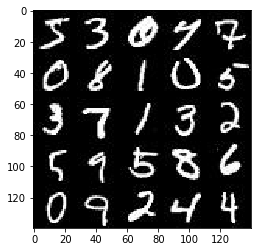

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

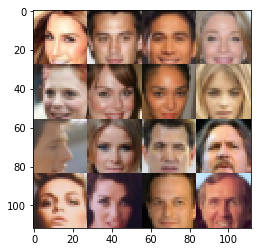

In [4]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


C:\Users\alceu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, 
                                shape=(None, image_width, image_height, image_channels), 
                                name='input_real')
    z_input = tf.placeholder(tf.float32, 
                             shape=(None, z_dim), 
                             name='noise_input')
    learn_rate = tf.placeholder(tf.float32, shape=(), name='learn_rate')

    return input_real, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input images are either 28x28x3 or 28x28x1.
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st Convolutional layer.
        conv1 = tf.layers.conv2d(images, 32, 5, 2, padding='same')
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (16, 16, 32)
        
        # 2nd Convolutional layer.
        conv2 = tf.layers.conv2d(conv1, 64, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2) # conv1.shape = (8, 8, 64)
        
        # 3rd Convolutional layer.
        conv3 = tf.layers.conv2d(conv2, 128, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3) # conv1.shape = (4, 4, 128)
        
        # Output layer.
        conv3 = tf.reshape(conv3, (-1, 4*4*128)) # Flatten.
        logits = tf.layers.dense(conv3, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :re
    turn: The tensor output of the generator
    """
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, units=7*7*512)
        x = tf.reshape(x, [-1, 7, 7, 512])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x) # x.shape = (7, 7, 512)
        
        # 1st Convolution.
        conv1 = tf.layers.conv2d_transpose(x, filters=256, kernel_size=5, 
                                           strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (14, 14, 256)
        
        # Convolution to output.
        logits = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 
                                            strides=2, padding='same')
        # logits.shape = (28, 28, out_channel_dim)
        out = 0.5 * tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    
    _, d_logits_real = discriminator(input_real, reuse=False)
    d_labels_real = tf.ones_like(d_logits_real) * (1.0 - smooth)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=d_labels_real))
    _, d_logits_fake = discriminator(input_fake, reuse=True)
    d_labels_fake = tf.zeros_like(d_logits_fake)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=d_labels_fake))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.split('/')[0] == 'generator']
    d_vars = [v for v in t_vars if v.name.split('/')[0] == 'discriminator']

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_counter = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):                
                
                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # Print generator output.
                batch_counter += 1
                if (batch_counter % 100) == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)
                    
                # Print losses.
                if (batch_counter % 10) == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch Count {}...".format(batch_counter),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch Count 10... Discriminator Loss: 0.4686... Generator Loss: 18.0051
Epoch 1/2... Batch Count 20... Discriminator Loss: 0.4360... Generator Loss: 5.3091
Epoch 1/2... Batch Count 30... Discriminator Loss: 0.4630... Generator Loss: 4.8882
Epoch 1/2... Batch Count 40... Discriminator Loss: 1.9859... Generator Loss: 0.4567
Epoch 1/2... Batch Count 50... Discriminator Loss: 0.7648... Generator Loss: 1.6876
Epoch 1/2... Batch Count 60... Discriminator Loss: 0.5230... Generator Loss: 2.4391
Epoch 1/2... Batch Count 70... Discriminator Loss: 1.4216... Generator Loss: 2.8886
Epoch 1/2... Batch Count 80... Discriminator Loss: 0.9803... Generator Loss: 1.5927
Epoch 1/2... Batch Count 90... Discriminator Loss: 1.0246... Generator Loss: 1.6777


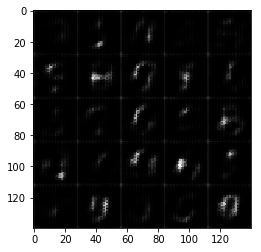

Epoch 1/2... Batch Count 100... Discriminator Loss: 0.8334... Generator Loss: 2.3433
Epoch 1/2... Batch Count 110... Discriminator Loss: 1.5638... Generator Loss: 0.8336
Epoch 1/2... Batch Count 120... Discriminator Loss: 0.8533... Generator Loss: 2.0059
Epoch 1/2... Batch Count 130... Discriminator Loss: 1.2299... Generator Loss: 1.1524
Epoch 1/2... Batch Count 140... Discriminator Loss: 1.5826... Generator Loss: 0.5491
Epoch 1/2... Batch Count 150... Discriminator Loss: 1.4130... Generator Loss: 0.5753
Epoch 1/2... Batch Count 160... Discriminator Loss: 0.9342... Generator Loss: 1.1955
Epoch 1/2... Batch Count 170... Discriminator Loss: 1.5433... Generator Loss: 0.4454
Epoch 1/2... Batch Count 180... Discriminator Loss: 0.9763... Generator Loss: 1.1831
Epoch 1/2... Batch Count 190... Discriminator Loss: 0.9802... Generator Loss: 1.0714


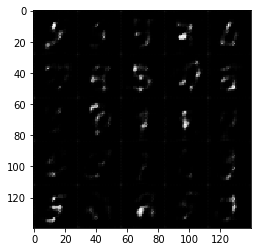

Epoch 1/2... Batch Count 200... Discriminator Loss: 1.0746... Generator Loss: 1.6344
Epoch 1/2... Batch Count 210... Discriminator Loss: 1.4123... Generator Loss: 0.6213
Epoch 1/2... Batch Count 220... Discriminator Loss: 1.3734... Generator Loss: 0.7114
Epoch 1/2... Batch Count 230... Discriminator Loss: 1.2262... Generator Loss: 0.8416
Epoch 1/2... Batch Count 240... Discriminator Loss: 0.9129... Generator Loss: 1.1453
Epoch 1/2... Batch Count 250... Discriminator Loss: 1.0501... Generator Loss: 1.7580
Epoch 1/2... Batch Count 260... Discriminator Loss: 0.9429... Generator Loss: 1.5383
Epoch 1/2... Batch Count 270... Discriminator Loss: 1.1699... Generator Loss: 1.1911
Epoch 1/2... Batch Count 280... Discriminator Loss: 0.9598... Generator Loss: 1.3028
Epoch 1/2... Batch Count 290... Discriminator Loss: 1.2119... Generator Loss: 1.6185


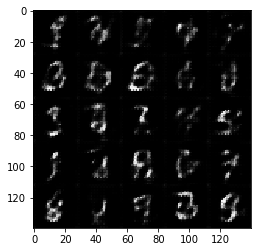

Epoch 1/2... Batch Count 300... Discriminator Loss: 1.5647... Generator Loss: 0.4666
Epoch 1/2... Batch Count 310... Discriminator Loss: 1.1777... Generator Loss: 0.7566
Epoch 1/2... Batch Count 320... Discriminator Loss: 1.1170... Generator Loss: 0.8529
Epoch 1/2... Batch Count 330... Discriminator Loss: 1.1518... Generator Loss: 0.9738
Epoch 1/2... Batch Count 340... Discriminator Loss: 1.2445... Generator Loss: 0.7646
Epoch 1/2... Batch Count 350... Discriminator Loss: 0.8899... Generator Loss: 1.3219
Epoch 1/2... Batch Count 360... Discriminator Loss: 1.0849... Generator Loss: 1.3653
Epoch 1/2... Batch Count 370... Discriminator Loss: 1.1793... Generator Loss: 0.8232
Epoch 1/2... Batch Count 380... Discriminator Loss: 1.0362... Generator Loss: 1.3842
Epoch 1/2... Batch Count 390... Discriminator Loss: 0.9405... Generator Loss: 1.3968


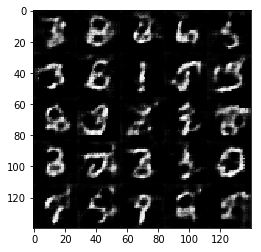

Epoch 1/2... Batch Count 400... Discriminator Loss: 1.0102... Generator Loss: 1.0499
Epoch 1/2... Batch Count 410... Discriminator Loss: 1.4614... Generator Loss: 0.5885
Epoch 1/2... Batch Count 420... Discriminator Loss: 1.2829... Generator Loss: 0.7548
Epoch 1/2... Batch Count 430... Discriminator Loss: 1.1238... Generator Loss: 1.0417
Epoch 1/2... Batch Count 440... Discriminator Loss: 1.3474... Generator Loss: 0.6263
Epoch 1/2... Batch Count 450... Discriminator Loss: 1.0627... Generator Loss: 0.9474
Epoch 1/2... Batch Count 460... Discriminator Loss: 1.0358... Generator Loss: 1.2584
Epoch 1/2... Batch Count 470... Discriminator Loss: 1.2976... Generator Loss: 0.6441
Epoch 1/2... Batch Count 480... Discriminator Loss: 1.2308... Generator Loss: 0.7529
Epoch 1/2... Batch Count 490... Discriminator Loss: 1.3874... Generator Loss: 0.7084


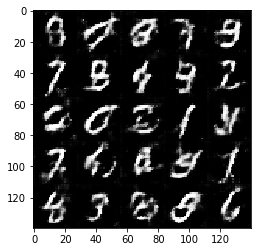

Epoch 1/2... Batch Count 500... Discriminator Loss: 1.1965... Generator Loss: 0.8376
Epoch 1/2... Batch Count 510... Discriminator Loss: 1.2550... Generator Loss: 0.9298
Epoch 1/2... Batch Count 520... Discriminator Loss: 0.9332... Generator Loss: 1.2007
Epoch 1/2... Batch Count 530... Discriminator Loss: 1.3614... Generator Loss: 0.6349
Epoch 1/2... Batch Count 540... Discriminator Loss: 1.1964... Generator Loss: 0.8967
Epoch 1/2... Batch Count 550... Discriminator Loss: 0.9302... Generator Loss: 1.3067
Epoch 1/2... Batch Count 560... Discriminator Loss: 0.9924... Generator Loss: 1.0519
Epoch 1/2... Batch Count 570... Discriminator Loss: 1.4494... Generator Loss: 0.4873
Epoch 1/2... Batch Count 580... Discriminator Loss: 1.1954... Generator Loss: 0.8821
Epoch 1/2... Batch Count 590... Discriminator Loss: 0.8658... Generator Loss: 1.3070


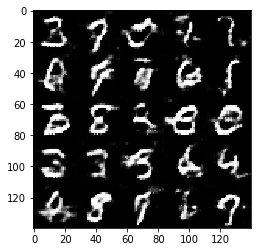

Epoch 1/2... Batch Count 600... Discriminator Loss: 1.4969... Generator Loss: 0.5635
Epoch 1/2... Batch Count 610... Discriminator Loss: 1.1179... Generator Loss: 0.8730
Epoch 1/2... Batch Count 620... Discriminator Loss: 1.1247... Generator Loss: 0.8180
Epoch 1/2... Batch Count 630... Discriminator Loss: 1.0575... Generator Loss: 1.0337
Epoch 1/2... Batch Count 640... Discriminator Loss: 1.1239... Generator Loss: 1.4311
Epoch 1/2... Batch Count 650... Discriminator Loss: 0.9563... Generator Loss: 1.0882
Epoch 1/2... Batch Count 660... Discriminator Loss: 1.1196... Generator Loss: 0.8051
Epoch 1/2... Batch Count 670... Discriminator Loss: 1.2029... Generator Loss: 1.1016
Epoch 1/2... Batch Count 680... Discriminator Loss: 0.9512... Generator Loss: 1.0008
Epoch 1/2... Batch Count 690... Discriminator Loss: 1.3927... Generator Loss: 0.5748


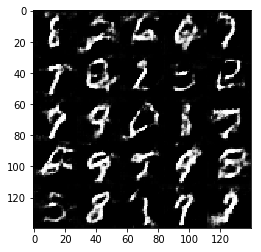

Epoch 1/2... Batch Count 700... Discriminator Loss: 0.8970... Generator Loss: 1.3453
Epoch 1/2... Batch Count 710... Discriminator Loss: 1.5198... Generator Loss: 0.4453
Epoch 1/2... Batch Count 720... Discriminator Loss: 1.1711... Generator Loss: 0.9689
Epoch 1/2... Batch Count 730... Discriminator Loss: 1.1121... Generator Loss: 1.1080
Epoch 1/2... Batch Count 740... Discriminator Loss: 1.1958... Generator Loss: 1.0676
Epoch 1/2... Batch Count 750... Discriminator Loss: 0.8889... Generator Loss: 1.1025
Epoch 1/2... Batch Count 760... Discriminator Loss: 0.8131... Generator Loss: 1.6275
Epoch 1/2... Batch Count 770... Discriminator Loss: 1.0166... Generator Loss: 1.4582
Epoch 1/2... Batch Count 780... Discriminator Loss: 0.9705... Generator Loss: 1.2258
Epoch 1/2... Batch Count 790... Discriminator Loss: 1.2390... Generator Loss: 1.0014


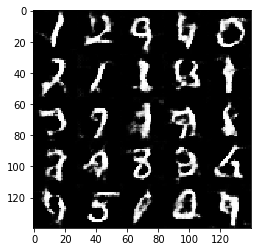

Epoch 1/2... Batch Count 800... Discriminator Loss: 1.3943... Generator Loss: 0.5363
Epoch 1/2... Batch Count 810... Discriminator Loss: 1.0144... Generator Loss: 1.4818
Epoch 1/2... Batch Count 820... Discriminator Loss: 0.8853... Generator Loss: 1.1842
Epoch 1/2... Batch Count 830... Discriminator Loss: 1.4862... Generator Loss: 0.4957
Epoch 1/2... Batch Count 840... Discriminator Loss: 1.0010... Generator Loss: 1.1134
Epoch 1/2... Batch Count 850... Discriminator Loss: 1.0168... Generator Loss: 1.0946
Epoch 1/2... Batch Count 860... Discriminator Loss: 1.1163... Generator Loss: 0.8283
Epoch 1/2... Batch Count 870... Discriminator Loss: 0.9683... Generator Loss: 1.1534
Epoch 1/2... Batch Count 880... Discriminator Loss: 2.2258... Generator Loss: 0.2257
Epoch 1/2... Batch Count 890... Discriminator Loss: 1.0766... Generator Loss: 1.0374


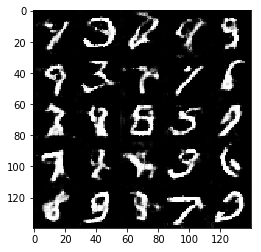

Epoch 1/2... Batch Count 900... Discriminator Loss: 0.7683... Generator Loss: 1.4928
Epoch 1/2... Batch Count 910... Discriminator Loss: 1.0358... Generator Loss: 0.9885
Epoch 1/2... Batch Count 920... Discriminator Loss: 0.8076... Generator Loss: 1.6828
Epoch 1/2... Batch Count 930... Discriminator Loss: 1.0117... Generator Loss: 1.0822
Epoch 1/2... Batch Count 940... Discriminator Loss: 1.2999... Generator Loss: 0.7052
Epoch 1/2... Batch Count 950... Discriminator Loss: 0.9534... Generator Loss: 1.1349
Epoch 1/2... Batch Count 960... Discriminator Loss: 0.9922... Generator Loss: 1.0145
Epoch 1/2... Batch Count 970... Discriminator Loss: 1.0080... Generator Loss: 0.9195
Epoch 1/2... Batch Count 980... Discriminator Loss: 0.8382... Generator Loss: 1.4905
Epoch 1/2... Batch Count 990... Discriminator Loss: 0.9948... Generator Loss: 0.9069


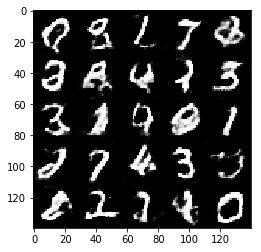

Epoch 1/2... Batch Count 1000... Discriminator Loss: 0.9175... Generator Loss: 1.0457
Epoch 1/2... Batch Count 1010... Discriminator Loss: 1.2385... Generator Loss: 0.6356
Epoch 1/2... Batch Count 1020... Discriminator Loss: 0.8301... Generator Loss: 1.2712
Epoch 1/2... Batch Count 1030... Discriminator Loss: 1.0449... Generator Loss: 1.0451
Epoch 1/2... Batch Count 1040... Discriminator Loss: 1.3133... Generator Loss: 0.6618
Epoch 1/2... Batch Count 1050... Discriminator Loss: 1.0795... Generator Loss: 0.8358
Epoch 1/2... Batch Count 1060... Discriminator Loss: 1.4686... Generator Loss: 0.5350
Epoch 1/2... Batch Count 1070... Discriminator Loss: 0.8581... Generator Loss: 1.4962
Epoch 1/2... Batch Count 1080... Discriminator Loss: 0.9033... Generator Loss: 1.2023
Epoch 1/2... Batch Count 1090... Discriminator Loss: 1.1774... Generator Loss: 0.7177


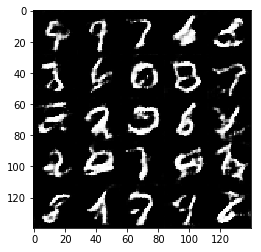

Epoch 1/2... Batch Count 1100... Discriminator Loss: 1.2424... Generator Loss: 0.6182
Epoch 1/2... Batch Count 1110... Discriminator Loss: 1.3795... Generator Loss: 0.5222
Epoch 1/2... Batch Count 1120... Discriminator Loss: 1.3558... Generator Loss: 2.2902
Epoch 1/2... Batch Count 1130... Discriminator Loss: 1.0502... Generator Loss: 0.8515
Epoch 1/2... Batch Count 1140... Discriminator Loss: 0.9402... Generator Loss: 1.2220
Epoch 1/2... Batch Count 1150... Discriminator Loss: 2.1949... Generator Loss: 0.2223
Epoch 1/2... Batch Count 1160... Discriminator Loss: 0.8925... Generator Loss: 1.2761
Epoch 1/2... Batch Count 1170... Discriminator Loss: 0.8921... Generator Loss: 1.1639
Epoch 1/2... Batch Count 1180... Discriminator Loss: 0.8666... Generator Loss: 1.1440


KeyboardInterrupt: 

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.6
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch Count 10... Discriminator Loss: 4.1290... Generator Loss: 0.0595
Epoch 1/1... Batch Count 20... Discriminator Loss: 3.1183... Generator Loss: 0.1689
Epoch 1/1... Batch Count 30... Discriminator Loss: 2.8807... Generator Loss: 0.2137
Epoch 1/1... Batch Count 40... Discriminator Loss: 2.0920... Generator Loss: 0.4785
Epoch 1/1... Batch Count 50... Discriminator Loss: 1.2947... Generator Loss: 1.5241
Epoch 1/1... Batch Count 60... Discriminator Loss: 2.0743... Generator Loss: 0.4915
Epoch 1/1... Batch Count 70... Discriminator Loss: 2.4958... Generator Loss: 0.4006
Epoch 1/1... Batch Count 80... Discriminator Loss: 2.0904... Generator Loss: 0.4245
Epoch 1/1... Batch Count 90... Discriminator Loss: 1.7050... Generator Loss: 1.3452


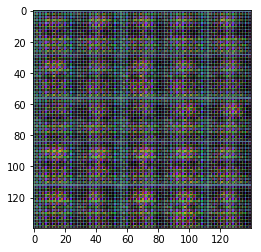

Epoch 1/1... Batch Count 100... Discriminator Loss: 1.2341... Generator Loss: 1.2853
Epoch 1/1... Batch Count 110... Discriminator Loss: 1.0500... Generator Loss: 1.3273
Epoch 1/1... Batch Count 120... Discriminator Loss: 1.4061... Generator Loss: 1.2417
Epoch 1/1... Batch Count 130... Discriminator Loss: 0.9465... Generator Loss: 1.7279
Epoch 1/1... Batch Count 140... Discriminator Loss: 1.0441... Generator Loss: 1.2772
Epoch 1/1... Batch Count 150... Discriminator Loss: 0.7747... Generator Loss: 1.4518
Epoch 1/1... Batch Count 160... Discriminator Loss: 0.7357... Generator Loss: 1.6431
Epoch 1/1... Batch Count 170... Discriminator Loss: 0.6778... Generator Loss: 2.2148
Epoch 1/1... Batch Count 180... Discriminator Loss: 0.7754... Generator Loss: 1.6481
Epoch 1/1... Batch Count 190... Discriminator Loss: 1.2365... Generator Loss: 0.9709


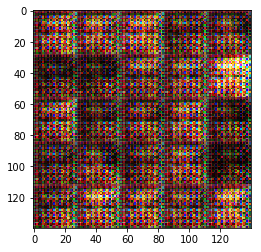

Epoch 1/1... Batch Count 200... Discriminator Loss: 1.4385... Generator Loss: 0.8502
Epoch 1/1... Batch Count 210... Discriminator Loss: 0.8063... Generator Loss: 2.7416
Epoch 1/1... Batch Count 220... Discriminator Loss: 0.9945... Generator Loss: 1.2868
Epoch 1/1... Batch Count 230... Discriminator Loss: 0.9202... Generator Loss: 1.1653
Epoch 1/1... Batch Count 240... Discriminator Loss: 0.9596... Generator Loss: 1.0397
Epoch 1/1... Batch Count 250... Discriminator Loss: 0.9368... Generator Loss: 1.2812
Epoch 1/1... Batch Count 260... Discriminator Loss: 0.9162... Generator Loss: 1.0934
Epoch 1/1... Batch Count 270... Discriminator Loss: 0.8220... Generator Loss: 1.5540
Epoch 1/1... Batch Count 280... Discriminator Loss: 0.7738... Generator Loss: 1.8708
Epoch 1/1... Batch Count 290... Discriminator Loss: 0.8105... Generator Loss: 1.5244


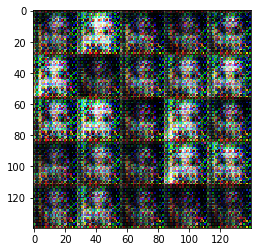

Epoch 1/1... Batch Count 300... Discriminator Loss: 0.5572... Generator Loss: 1.9400
Epoch 1/1... Batch Count 310... Discriminator Loss: 0.6883... Generator Loss: 2.4119
Epoch 1/1... Batch Count 320... Discriminator Loss: 0.5844... Generator Loss: 2.3485
Epoch 1/1... Batch Count 330... Discriminator Loss: 0.4991... Generator Loss: 2.3675
Epoch 1/1... Batch Count 340... Discriminator Loss: 0.5839... Generator Loss: 1.7453
Epoch 1/1... Batch Count 350... Discriminator Loss: 0.4206... Generator Loss: 3.9821
Epoch 1/1... Batch Count 360... Discriminator Loss: 0.7163... Generator Loss: 1.7500
Epoch 1/1... Batch Count 370... Discriminator Loss: 0.4567... Generator Loss: 2.4833
Epoch 1/1... Batch Count 380... Discriminator Loss: 0.5096... Generator Loss: 2.7862
Epoch 1/1... Batch Count 390... Discriminator Loss: 0.6016... Generator Loss: 1.5847


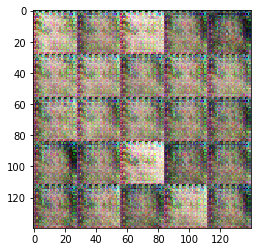

Epoch 1/1... Batch Count 400... Discriminator Loss: 1.2882... Generator Loss: 1.1264
Epoch 1/1... Batch Count 410... Discriminator Loss: 1.8293... Generator Loss: 0.3895
Epoch 1/1... Batch Count 420... Discriminator Loss: 1.1934... Generator Loss: 1.0018
Epoch 1/1... Batch Count 430... Discriminator Loss: 0.4809... Generator Loss: 3.9773
Epoch 1/1... Batch Count 440... Discriminator Loss: 3.3836... Generator Loss: 0.3183
Epoch 1/1... Batch Count 450... Discriminator Loss: 3.1345... Generator Loss: 0.1512
Epoch 1/1... Batch Count 460... Discriminator Loss: 1.6057... Generator Loss: 0.9082
Epoch 1/1... Batch Count 470... Discriminator Loss: 2.0922... Generator Loss: 0.6635
Epoch 1/1... Batch Count 480... Discriminator Loss: 1.6211... Generator Loss: 0.7309
Epoch 1/1... Batch Count 490... Discriminator Loss: 2.2075... Generator Loss: 0.4353


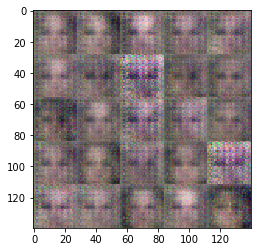

Epoch 1/1... Batch Count 500... Discriminator Loss: 2.2616... Generator Loss: 0.6829
Epoch 1/1... Batch Count 510... Discriminator Loss: 1.8973... Generator Loss: 0.5412
Epoch 1/1... Batch Count 520... Discriminator Loss: 2.1530... Generator Loss: 0.5357
Epoch 1/1... Batch Count 530... Discriminator Loss: 2.0742... Generator Loss: 0.5581
Epoch 1/1... Batch Count 540... Discriminator Loss: 1.3202... Generator Loss: 0.9749
Epoch 1/1... Batch Count 550... Discriminator Loss: 1.8484... Generator Loss: 0.5276
Epoch 1/1... Batch Count 560... Discriminator Loss: 2.2805... Generator Loss: 0.5251
Epoch 1/1... Batch Count 570... Discriminator Loss: 2.2371... Generator Loss: 0.6601
Epoch 1/1... Batch Count 580... Discriminator Loss: 1.4172... Generator Loss: 0.8812
Epoch 1/1... Batch Count 590... Discriminator Loss: 2.1138... Generator Loss: 0.5107


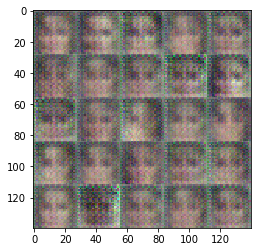

Epoch 1/1... Batch Count 600... Discriminator Loss: 2.4148... Generator Loss: 0.7912
Epoch 1/1... Batch Count 610... Discriminator Loss: 1.7053... Generator Loss: 0.8332
Epoch 1/1... Batch Count 620... Discriminator Loss: 1.4878... Generator Loss: 0.7009
Epoch 1/1... Batch Count 630... Discriminator Loss: 2.2853... Generator Loss: 0.6474
Epoch 1/1... Batch Count 640... Discriminator Loss: 1.8046... Generator Loss: 0.7270
Epoch 1/1... Batch Count 650... Discriminator Loss: 1.3934... Generator Loss: 0.7210
Epoch 1/1... Batch Count 660... Discriminator Loss: 1.6010... Generator Loss: 0.6163
Epoch 1/1... Batch Count 670... Discriminator Loss: 1.8297... Generator Loss: 0.6250
Epoch 1/1... Batch Count 680... Discriminator Loss: 2.2094... Generator Loss: 0.6039
Epoch 1/1... Batch Count 690... Discriminator Loss: 1.6871... Generator Loss: 0.7387


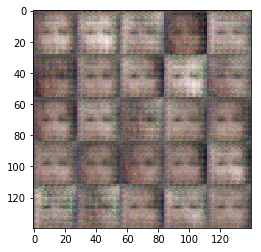

Epoch 1/1... Batch Count 700... Discriminator Loss: 1.4529... Generator Loss: 0.7554
Epoch 1/1... Batch Count 710... Discriminator Loss: 1.4376... Generator Loss: 0.7995
Epoch 1/1... Batch Count 720... Discriminator Loss: 1.7328... Generator Loss: 0.6894
Epoch 1/1... Batch Count 730... Discriminator Loss: 1.4619... Generator Loss: 0.8359
Epoch 1/1... Batch Count 740... Discriminator Loss: 1.4997... Generator Loss: 0.7195
Epoch 1/1... Batch Count 750... Discriminator Loss: 1.6610... Generator Loss: 0.6555
Epoch 1/1... Batch Count 760... Discriminator Loss: 1.6585... Generator Loss: 0.6701
Epoch 1/1... Batch Count 770... Discriminator Loss: 1.6876... Generator Loss: 0.7043
Epoch 1/1... Batch Count 780... Discriminator Loss: 1.6671... Generator Loss: 0.6460
Epoch 1/1... Batch Count 790... Discriminator Loss: 1.5496... Generator Loss: 0.8257


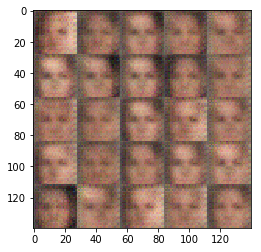

Epoch 1/1... Batch Count 800... Discriminator Loss: 1.6514... Generator Loss: 0.7665
Epoch 1/1... Batch Count 810... Discriminator Loss: 1.4638... Generator Loss: 0.8727
Epoch 1/1... Batch Count 820... Discriminator Loss: 1.7543... Generator Loss: 0.6313
Epoch 1/1... Batch Count 830... Discriminator Loss: 1.6190... Generator Loss: 0.7118
Epoch 1/1... Batch Count 840... Discriminator Loss: 1.7729... Generator Loss: 0.7326
Epoch 1/1... Batch Count 850... Discriminator Loss: 1.6167... Generator Loss: 0.7393
Epoch 1/1... Batch Count 860... Discriminator Loss: 1.5885... Generator Loss: 0.7699
Epoch 1/1... Batch Count 870... Discriminator Loss: 1.3851... Generator Loss: 0.7802
Epoch 1/1... Batch Count 880... Discriminator Loss: 1.3684... Generator Loss: 0.7781
Epoch 1/1... Batch Count 890... Discriminator Loss: 1.3695... Generator Loss: 0.8320


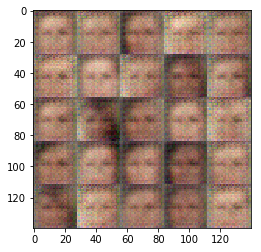

Epoch 1/1... Batch Count 900... Discriminator Loss: 1.5992... Generator Loss: 0.6883
Epoch 1/1... Batch Count 910... Discriminator Loss: 1.8408... Generator Loss: 0.6005
Epoch 1/1... Batch Count 920... Discriminator Loss: 1.6438... Generator Loss: 0.6879
Epoch 1/1... Batch Count 930... Discriminator Loss: 1.6643... Generator Loss: 0.7311
Epoch 1/1... Batch Count 940... Discriminator Loss: 1.4904... Generator Loss: 0.8828
Epoch 1/1... Batch Count 950... Discriminator Loss: 1.5835... Generator Loss: 0.7601
Epoch 1/1... Batch Count 960... Discriminator Loss: 1.7779... Generator Loss: 0.7618
Epoch 1/1... Batch Count 970... Discriminator Loss: 1.6609... Generator Loss: 0.7007
Epoch 1/1... Batch Count 980... Discriminator Loss: 1.6339... Generator Loss: 0.6631
Epoch 1/1... Batch Count 990... Discriminator Loss: 1.5805... Generator Loss: 0.7735


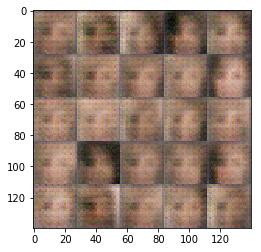

Epoch 1/1... Batch Count 1000... Discriminator Loss: 1.5065... Generator Loss: 0.6996
Epoch 1/1... Batch Count 1010... Discriminator Loss: 1.4505... Generator Loss: 0.6963
Epoch 1/1... Batch Count 1020... Discriminator Loss: 1.6512... Generator Loss: 0.6269
Epoch 1/1... Batch Count 1030... Discriminator Loss: 1.6394... Generator Loss: 0.6663
Epoch 1/1... Batch Count 1040... Discriminator Loss: 1.3631... Generator Loss: 0.8757
Epoch 1/1... Batch Count 1050... Discriminator Loss: 1.3426... Generator Loss: 0.7591
Epoch 1/1... Batch Count 1060... Discriminator Loss: 1.5964... Generator Loss: 0.6822
Epoch 1/1... Batch Count 1070... Discriminator Loss: 2.2180... Generator Loss: 0.4069
Epoch 1/1... Batch Count 1080... Discriminator Loss: 2.1094... Generator Loss: 0.6204
Epoch 1/1... Batch Count 1090... Discriminator Loss: 1.3805... Generator Loss: 1.0238


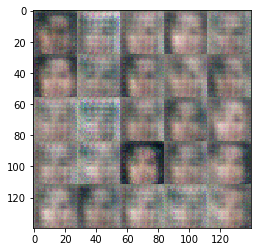

Epoch 1/1... Batch Count 1100... Discriminator Loss: 1.4831... Generator Loss: 0.7462
Epoch 1/1... Batch Count 1110... Discriminator Loss: 2.0868... Generator Loss: 0.5050
Epoch 1/1... Batch Count 1120... Discriminator Loss: 1.7461... Generator Loss: 0.6859
Epoch 1/1... Batch Count 1130... Discriminator Loss: 1.4336... Generator Loss: 0.9422
Epoch 1/1... Batch Count 1140... Discriminator Loss: 1.5382... Generator Loss: 0.8397
Epoch 1/1... Batch Count 1150... Discriminator Loss: 1.6526... Generator Loss: 0.6996
Epoch 1/1... Batch Count 1160... Discriminator Loss: 1.6527... Generator Loss: 0.7981
Epoch 1/1... Batch Count 1170... Discriminator Loss: 1.3660... Generator Loss: 0.8934
Epoch 1/1... Batch Count 1180... Discriminator Loss: 1.3413... Generator Loss: 0.8862
Epoch 1/1... Batch Count 1190... Discriminator Loss: 1.5459... Generator Loss: 0.7423


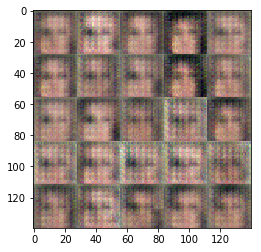

Epoch 1/1... Batch Count 1200... Discriminator Loss: 2.1658... Generator Loss: 0.6304
Epoch 1/1... Batch Count 1210... Discriminator Loss: 1.9818... Generator Loss: 0.6209
Epoch 1/1... Batch Count 1220... Discriminator Loss: 1.3994... Generator Loss: 1.0717
Epoch 1/1... Batch Count 1230... Discriminator Loss: 1.1046... Generator Loss: 0.9482
Epoch 1/1... Batch Count 1240... Discriminator Loss: 1.7070... Generator Loss: 0.7138
Epoch 1/1... Batch Count 1250... Discriminator Loss: 2.1777... Generator Loss: 0.6406
Epoch 1/1... Batch Count 1260... Discriminator Loss: 1.6766... Generator Loss: 0.7743
Epoch 1/1... Batch Count 1270... Discriminator Loss: 1.3175... Generator Loss: 0.9460
Epoch 1/1... Batch Count 1280... Discriminator Loss: 1.4981... Generator Loss: 0.8733
Epoch 1/1... Batch Count 1290... Discriminator Loss: 1.7799... Generator Loss: 0.7981


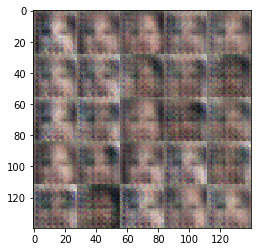

Epoch 1/1... Batch Count 1300... Discriminator Loss: 1.3886... Generator Loss: 0.8716
Epoch 1/1... Batch Count 1310... Discriminator Loss: 1.3903... Generator Loss: 0.7282
Epoch 1/1... Batch Count 1320... Discriminator Loss: 1.5585... Generator Loss: 0.7736
Epoch 1/1... Batch Count 1330... Discriminator Loss: 1.8727... Generator Loss: 0.7063
Epoch 1/1... Batch Count 1340... Discriminator Loss: 1.5280... Generator Loss: 0.7656
Epoch 1/1... Batch Count 1350... Discriminator Loss: 1.3470... Generator Loss: 0.8461
Epoch 1/1... Batch Count 1360... Discriminator Loss: 1.4719... Generator Loss: 0.7658
Epoch 1/1... Batch Count 1370... Discriminator Loss: 1.5744... Generator Loss: 0.8004
Epoch 1/1... Batch Count 1380... Discriminator Loss: 1.6788... Generator Loss: 0.6636
Epoch 1/1... Batch Count 1390... Discriminator Loss: 1.6691... Generator Loss: 0.6050


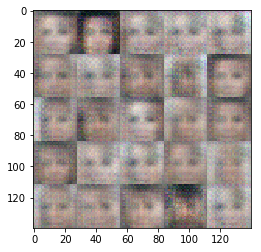

Epoch 1/1... Batch Count 1400... Discriminator Loss: 1.6944... Generator Loss: 0.7098
Epoch 1/1... Batch Count 1410... Discriminator Loss: 1.6571... Generator Loss: 0.8374
Epoch 1/1... Batch Count 1420... Discriminator Loss: 1.3232... Generator Loss: 0.9828
Epoch 1/1... Batch Count 1430... Discriminator Loss: 1.3979... Generator Loss: 0.7075
Epoch 1/1... Batch Count 1440... Discriminator Loss: 1.6310... Generator Loss: 0.6699
Epoch 1/1... Batch Count 1450... Discriminator Loss: 1.9179... Generator Loss: 0.6910
Epoch 1/1... Batch Count 1460... Discriminator Loss: 1.6451... Generator Loss: 0.7478
Epoch 1/1... Batch Count 1470... Discriminator Loss: 1.5330... Generator Loss: 0.7361
Epoch 1/1... Batch Count 1480... Discriminator Loss: 1.5296... Generator Loss: 0.7525
Epoch 1/1... Batch Count 1490... Discriminator Loss: 1.5481... Generator Loss: 0.7921


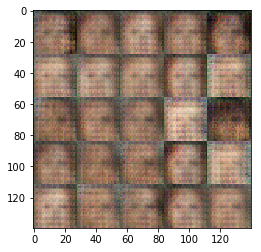

Epoch 1/1... Batch Count 1500... Discriminator Loss: 1.4620... Generator Loss: 0.7984
Epoch 1/1... Batch Count 1510... Discriminator Loss: 1.4350... Generator Loss: 0.8586
Epoch 1/1... Batch Count 1520... Discriminator Loss: 1.4577... Generator Loss: 0.7824
Epoch 1/1... Batch Count 1530... Discriminator Loss: 1.5908... Generator Loss: 0.6991
Epoch 1/1... Batch Count 1540... Discriminator Loss: 1.4994... Generator Loss: 0.7031
Epoch 1/1... Batch Count 1550... Discriminator Loss: 1.3520... Generator Loss: 0.7801
Epoch 1/1... Batch Count 1560... Discriminator Loss: 1.5817... Generator Loss: 0.7032
Epoch 1/1... Batch Count 1570... Discriminator Loss: 1.6337... Generator Loss: 0.6765


OSError: cannot identify image file './data\\img_align_celeba\\073183.jpg'

In [96]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.